In [1]:
#!pip install qiskit matplotlib pylatexenc networkx scipy

En primer lugar vamos a importar las bibliotecas necesarias

In [2]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer
from qiskit.visualization import plot_histogram
from networkx import Graph, draw
from scipy.optimize import minimize
import numpy as np

Vamos a construir el circuito a partir del grafo y un vector que contiene los parámetros γ y β

In [3]:
def int_to_binary_var(low, high):
    diff = high - low
    ans = [2**p for p in range(diff.bit_length()-1)]
    ans += [diff - sum(ans)]
    return ans

In [4]:
def create_matrix(size, data, functions):
    """
    
    size: (int) the number of qbits to use
    data: (dict) the data for the problem
    functions: (iterable(function: np.array, dict -> array)) a list of all function to apply to the matrix
    
    return: (np.array) the matrix produced by applying every function
    """
    mat = np.zeros((size, size))
    for f in functions:
        f(mat, data)
    return mat

In [5]:
def apply_linear_function(eq, keys, size, offset=0, start=0, end=None):
    """
    This function returns a function which applies a linear equation on a matrix' diagonal
    
    eq: (function: int, **args) a linear function with a position as first argument and every variable
    keys: (list(string)) a list of variables names from the input data dict used by eq
    size: (int) the size of the input matrix
    offset: (int) the difference between a matrix position and the position of it's data values
    start: (int) the first position to apply function onto
    end: (int) the value after the last position
    
    return (function: np.array , dict -> np.array) The array is modified by the function
    """
    if end == None:
        end = size
    assert(start - offset >= 0 and start < end and end <= size)
    
    def linear_f(matrix,data):
        for i in range(start,end):
            matrix[i,i] += eq(i - offset, *[data[k] for k in keys])
        return matrix
    
    return linear_f

In [6]:
def apply_quadratic_function(eq, keys, size, offset_i=0, start_i=0, end_i=None, start_j=0, end_j=None, offset_j=0):
    """
    This function returns a function which applies an equation on a matrix mixed terms
    
    eq: (function: int, **args) a linear function with a position as first argument and every variable
    keys: (list(string)) a list of variables names from the input data dict used by eq
    size: (int) the size of the input matrix
    offset_i: (int) the difference between the i position and the position of it's data values
    start_i: (int) the first i position to apply function onto
    end_i: (int) the value after the last i position
    offset_j: (int) the difference between the j position and the position of it's data values
    start_j: (int) the first j position to apply function onto
    end_j: (int) the value after the last j position

    
    return (function: np.array , dict -> np.array) The array is modified by the function
    """
    
    
    if end_i == None:
        end_i = size
    if end_j == None:
        end_j = size
    assert(start_i - offset_i >= 0 and start_i < end_i and end_i <= size)
    assert(start_j - offset_j >= 0 and start_j < end_j and end_j <= size)
    
    def quadratic_f(matrix, data):
        for i in range(start_i, end_i):
            for j in range(start_j,end_j):
                if i < j:
                    val = eq(i-offset_i, j-offset_j, *[data[k] for k in keys[0]], *[data[k] for k in keys[1]])
                    matrix[i,j] += val
                    matrix[j,i] += val
        return matrix
    
    return quadratic_f

In [7]:
def pack_knapsack_data(v, w, C):
    """
    This function takes knapsack data input and returns the dictionnary used for creating a matrix
    """
    data = {'v': v, 'w':w, 'C': C, 'P': sum(v), "start_i":0, "end_i" : len(v)}
    data['r'] = int_to_binary_var(0,C)
    data["start_j"] = data['end_i']
    data["end_j"] = data["start_j"] + len(data['r'])
    data['size'] = data["end_j"]
    data["j_offset"] = data["start_j"]
    data["0"] = [0 for _ in range(data["size"])]
    return data

In [67]:
def knapsack_QUBO_matrix(V, W, C):
    """
    This function takes knapsack input and returns the corresponding QUBO matrix
    """
    data = pack_knapsack_data(V, W, C)
    eq1 = lambda i, v, w, P, C: v[i] - P*(w[i]**2) + 2*P*C*w[i]
    k1 = ["v","w","P","C"]
    k2 = ["0","r", "P", "C"]

    f = []
    f.append(apply_linear_function(eq1, k1,data["end_i"]))
    f.append(apply_linear_function(eq1, k2 ,data["end_j"], start=data["start_j"], end= data["end_j"], offset=data["j_offset"]))

    eq2 = lambda i, j , w, P, r: -2* P*w[i] * r[j]
    k3 = [["w", 'P'],['w']]
    k4 = [['r', 'P'], ['r']]
    k5 = [['w', 'P'], ['r']]
    f.append(apply_quadratic_function(eq2, k3, data['size'], end_i=data["end_i"], end_j=data["end_i"]))
    f.append(apply_quadratic_function(eq2, k4, data['size'], start_i=data["start_j"], end_i=data["end_j"], offset_i=data["start_j"], start_j=data["start_j"], end_j=data["end_j"], offset_j=data["start_j"]))
    f.append(apply_quadratic_function(eq2, k5, data['size'], start_i=data["start_i"], end_i=data["end_i"], offset_i=data["start_i"], start_j=data["start_j"], end_j=data["end_j"], offset_j=data["start_j"],))

    return -create_matrix(data["size"], data, f), data["P"]*(C**2)

In [125]:
def QUBO_to_Ising(matrix, c):
    """
    This function takes a QUBO matrix + the constant and returns the corresponding Ising model
    """
    size = matrix.shape[0]
    h = np.zeros(size)
    J = np.zeros((size,size))
    
    
    J[0,0] = c + 1/4*(np.sum(matrix))
    for i in range(size):
        # Following the formula given, if I'm not mistaken it should be this formula for h[i]
        #h[i] = -1/2*(np.sum(matrix[i]))
        # However, when I use the built-in function from dwave to convert a BQM into an Ising problem I get this value instead
        h[i] =  1/4*(np.sum(matrix[i]) +matrix[i,i])

        for j in range(size):
            if i!=j:
                J[i,j] = 1/4 * matrix[i,j]
  
    
    return h, J

In order to check the value of my Ising model I used the implementation from dwave

In [129]:
v = [1,2,3]
w = [1,2,3]
c = 5
Q, C= knapsack_QUBO_matrix(v,w,c)
Q, QUBO_to_Ising(Q, C), C

(array([[ -55.,   24.,   36.,   12.,   24.,   24.],
        [  24.,  -98.,   72.,   24.,   48.,   48.],
        [  36.,   72., -129.,   36.,   72.,   72.],
        [  12.,   24.,   36.,  -54.,   24.,   24.],
        [  24.,   48.,   72.,   24.,  -96.,   48.],
        [  24.,   48.,   72.,   24.,   48.,  -96.]]),
 (array([2.5, 5. , 7.5, 3. , 6. , 6. ]),
  array([[312.,   6.,   9.,   3.,   6.,   6.],
         [  6.,   0.,  18.,   6.,  12.,  12.],
         [  9.,  18.,   0.,   9.,  18.,  18.],
         [  3.,   6.,   9.,   0.,   6.,   6.],
         [  6.,  12.,  18.,   6.,   0.,  12.],
         [  6.,  12.,  18.,   6.,  12.,   0.]])),
 150)

In [130]:
from dimod import Binary, ExactSolver
from networkx import Graph, draw
from dwave.samplers import SimulatedAnnealingSampler, SteepestDescentSampler
from dwave.system import DWaveSampler, EmbeddingComposite

In [134]:
def QUBO_knapsack_bin(w, v, C):

    nvars = len(w)
    r = int_to_binary_var(0, C)
    b = [Binary(f'b{i}') for i in range (0,nvars)]
    p =[Binary(f'p{i}') for i in range (0,len(r))]
    pen = sum([max(0,x) for x in v])
    qubo = (sum([((v[i]*b[i])) for i in range(nvars)]) 
             - pen* ((C - sum([w[i]*b[i] for i in range(nvars)]) 
                      - sum([p[j]* r[j] for j in range(len(r))]))**2))
    return -qubo

In [135]:
qubo = QUBO_knapsack_bin(w,v,c)
qubo.to_ising()

({'b0': 2.5, 'b1': 5.0, 'b2': 7.5, 'p0': 3.0, 'p1': 6.0, 'p2': 6.0},
 {('b1', 'b0'): 6.0,
  ('b2', 'b0'): 9.0,
  ('b2', 'b1'): 18.0,
  ('p0', 'b0'): 3.0,
  ('p0', 'b1'): 6.0,
  ('p0', 'b2'): 9.0,
  ('p1', 'b0'): 6.0,
  ('p1', 'b1'): 12.0,
  ('p1', 'b2'): 18.0,
  ('p1', 'p0'): 6.0,
  ('p2', 'b0'): 6.0,
  ('p2', 'b1'): 12.0,
  ('p2', 'b2'): 18.0,
  ('p2', 'p0'): 6.0,
  ('p2', 'p1'): 12.0},
 33.0)

In [136]:
def obtener_circuito_knapsack_b(W, V, C, theta):
    p = int_to_binary_var(0, C)
    nqubits = len(V) + len(p)

    circuito = QuantumCircuit(nqubits)
    it = len(theta)//2
    

    gamma = theta[:it]
    beta = theta[it:]
    
    Q, Qc = knapsack_QUBO_matrix(V, W, C)
    h, J = QUBO_to_Ising(Q, Qc)

    # Preparamos una superposición de todos los estados con puertas de Hadamard
    for i in range(0, nqubits):
        circuito.h(i)
  
  # Repetimos p veces los circuitos con el Hamiltoniano del problema y de mezcla
    for cnt in range(0,it):
        # Circuito con el Hamiltoniano del problema
        for i in range(nqubits):
            circuito.rz(2*gamma[cnt]*h[i], i)
            
        for i in range(nqubits):    
            for j in range(nqubits):
                if i != j:
                    circuito.rzz(2*gamma[cnt]*J[i,j], i ,j)
        
        # Circuito con el Hamitoniano de mezcla
        for qbit in range(0,nqubits):
            circuito.rx(beta[cnt], qbit)

    # Medida para obtener una solución
    circuito.measure_all()

    return circuito

In [104]:
entorno = Aer.get_backend('qasm_simulator')

def ejecuta_circuito(W, V, C, theta, ejecuciones=1e8):      
    circuito = obtener_circuito_knapsack_b(W, V, C, theta)
    histograma = entorno.run(circuito, shots=ejecuciones).result().get_counts()
    return histograma

In [105]:
import math
def funcion_objetivo(W, V, C, ejecuciones=10000):
    
  def calculate_value(solucion):
    pen = sum([abs(x) for x in V])
    b = int_to_binary_var(0,C)
    w = W + b
    v = V + [0 for _ in b]
    
    obj = 0
    weight_total = 0
    for cnt,bit in enumerate(solucion):
        obj += int(bit)*v[cnt]
        weight_total += int(bit)*w[cnt]
        
    obj -= pen*((C - weight_total)**2)
    return obj
    
  def ejecuta_calcula_promedio(theta):
    histograma = ejecuta_circuito(W,V, C, theta, ejecuciones=ejecuciones)
    suma = 0
    ejecs = 0
    best = math.inf
    for solucion, veces in histograma.items():
        objective_value = calculate_value(solucion[::-1])
        #if objective_value < best:
         #   suma = objective_value * veces
          #  ejecs = veces
           # best = veces
        #elif objective_value == best:
        suma += objective_value * veces
        ejecs += veces

    return -suma/ejecs
    
  return ejecuta_calcula_promedio


Ahora solo nos queda utilizar un algoritmo de optimización clásico para resolver el problema. Aquí usaremos SLSQP de SciPy.

In [106]:
def maximiza(W, V, C, theta, ejecuciones=1000):
  objetivo = funcion_objetivo(W,V,C, ejecuciones=ejecuciones)
  return minimize(objetivo,theta, method='COBYLA')
  

My results end up being unconvicing at best

In [144]:
C = 5
W = [1,2,3]
V = [1,2,3]

In [145]:
n = 10
tries = 1
ans = None
for x in range(tries):
    theta = [1+1/(n+1) for i in range(n)] + [1+ 1/(n+1) for i in range(n)]
    resultado = maximiza(W,V,C, theta[::-1], ejecuciones=int(1e5))
    histograma = ejecuta_circuito(W, V ,C, resultado.x, ejecuciones=int(1e5))
    if ans == None:
        ans = histograma
    else:
        ans = {key : histograma[key] if not key in ans else ans[key] + histograma[key] for key in histograma.keys()}

In [146]:
plot_histogram(ans)

In [147]:
{k[::-1]: v for k, v in sorted(ans.items(), key=lambda item: item[1], reverse=True)}

{'000011': 9809,
 '011100': 4498,
 '100111': 3943,
 '100110': 3891,
 '100101': 3746,
 '001101': 3656,
 '001110': 3655,
 '001100': 3630,
 '100011': 3621,
 '011000': 3414,
 '110100': 3149,
 '010111': 3125,
 '101000': 2337,
 '011110': 2320,
 '011101': 2286,
 '000111': 2216,
 '100010': 2206,
 '100001': 2101,
 '001000': 2087,
 '001001': 1907,
 '001010': 1814,
 '001111': 1802,
 '111000': 1650,
 '100000': 1579,
 '001011': 1469,
 '110001': 1377,
 '110010': 1374,
 '111110': 1278,
 '111101': 1258,
 '010000': 1076,
 '010110': 1067,
 '101010': 1063,
 '010101': 1040,
 '101001': 1021,
 '000101': 990,
 '000110': 984,
 '011001': 971,
 '011010': 955,
 '010001': 876,
 '010010': 813,
 '110000': 743,
 '110110': 673,
 '101111': 672,
 '110101': 664,
 '111011': 530,
 '101011': 520,
 '100100': 495,
 '010100': 472,
 '010011': 410,
 '101110': 390,
 '101101': 382,
 '110111': 378,
 '111010': 292,
 '111001': 273,
 '000100': 220,
 '111100': 189,
 '000000': 127,
 '011011': 124,
 '101100': 118,
 '110011': 101,
 '0111

In [148]:
resultado.x

array([1.09086386, 1.08964259, 2.08985505, 1.09520782, 1.09457796,
       1.08232308, 1.09370641, 1.09073958, 1.12324999, 0.97594136,
       1.10709432, 1.11595005, 1.04640878, 1.06590174, 1.17426462,
       0.99288929, 1.08677658, 1.09441154, 1.09167627, 1.09418134])

In [61]:
C = 10
W = [1,2,3,4,5]
V = [10,20,30,40,50]

In [62]:
n = 8
tries = 1
ans = None
for x in range(tries):
    theta = [1+1/(n+1) for i in range(n)] + [1+ 1/(n+1) for i in range(n)]
    resultado = maximiza(W,V,C, theta[::-1], ejecuciones=int(1e4))
    histograma = ejecuta_circuito(W, V ,C, resultado.x, ejecuciones=int(1e5))
    if ans == None:
        ans = histograma
    else:
        ans = {key : histograma[key] if not key in ans else ans[key] + histograma[key] for key in histograma.keys()}

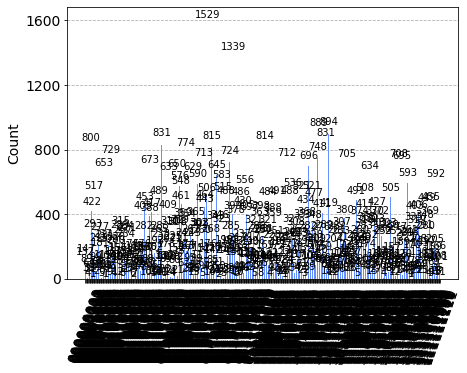

In [63]:
plot_histogram(ans)

In [64]:
{k[::-1]: v for k, v in sorted(ans.items(), key=lambda item: item[1], reverse=True)}

{'100011010': 1529,
 '101010110': 1339,
 '111110101': 894,
 '100010101': 889,
 '110110101': 831,
 '101101100': 831,
 '011011010': 815,
 '110000001': 814,
 '000100000': 800,
 '100010010': 774,
 '111100101': 748,
 '101001000': 729,
 '000010110': 724,
 '110101010': 713,
 '010001001': 712,
 '110000111': 708,
 '100111101': 705,
 '010000101': 696,
 '000100111': 695,
 '101110100': 673,
 '110110000': 653,
 '001000010': 650,
 '101111010': 645,
 '010110011': 634,
 '000111100': 633,
 '110110010': 629,
 '000010111': 593,
 '100111111': 592,
 '010001010': 590,
 '001000110': 583,
 '000100010': 576,
 '101001110': 556,
 '010100010': 548,
 '110101001': 536,
 '100111001': 521,
 '111000101': 521,
 '001100000': 517,
 '011000110': 515,
 '010010011': 508,
 '111101010': 506,
 '000111011': 505,
 '001010001': 491,
 '111000011': 491,
 '010101100': 489,
 '110100110': 488,
 '111001001': 488,
 '000001110': 486,
 '111000001': 484,
 '010100101': 477,
 '101101010': 464,
 '110100010': 461,
 '010011111': 455,
 '10101010